### Bài toán: Dự đoán doanh thu của game dựa trên các tiêu chí ban đầu của nó.
 - Sử dụng 2 mô hình:
    + Support vector regression
    + Linear regression

### Thông tin dữ liệu
  - Số lượng mẫu: 1381 (thông tin từ 1381 game khác nhau)
  - Các cột dữ liệu:
      + Name (tên của game, không dùng để train và test)
      + Publisher (nhát phát hành của game)
      + Price (giá của game, đơn vị là dola)
      + Net Revenue (tổng doanh thu của game, đơn vị là triệu dola)
      + Platform (nền tản phân phối game)
      + Genres (thể loại của game)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn import linear_model

In [2]:
view = pd.read_csv("view.csv")
view.head()

,Name,Pulisher,Price,Net Revenue,Platform,Genres,Platform_text,Genres_text,Pulisher_text
0,Grand Theft Auto V,422,29.99,700.0,0,1,Windows,"Action,Adventure",Rockstar Games
1,Cyberpunk 2077,91,59.99,490.0,0,207,Windows,RPG,CD PROJEKT RED
2,Rust,188,39.99,490.0,3,36,Windows Mac,"Action,Adventure,Indie,MassivelyMultiplayer,RPG",Facepunch Studios
3,The Witcher® 3: Wild Hunt,91,39.99,430.0,0,207,Windows,RPG,CD PROJEKT RED
4,Tom Clancy's Rainbow Six® Siege,549,19.99,340.0,0,0,Windows,Action,Ubisoft


In [28]:
df = pd.read_csv("clean_data.csv")
print(df.shape)
df.head()

(1381, 6)


,Name,Pulisher,Price,Net Revenue,Platform,Genres
0,Grand Theft Auto V,422,29.99,700.0,0,1
1,Cyberpunk 2077,91,59.99,490.0,0,207
2,Rust,188,39.99,490.0,3,36
3,The Witcher® 3: Wild Hunt,91,39.99,430.0,0,207
4,Tom Clancy's Rainbow Six® Siege,549,19.99,340.0,0,0


#### Histogram của biến Net Reveunue(tổng doanh thu)
-  đồ thị lệch trái, đa số đều nằm dưới mức 100 triệu đô, chiếm phần lớn là dưới 20 triệu đô

-  chút nữa xử lý ngoại lệ theo IQR

g:\Code\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Net Revenue'>

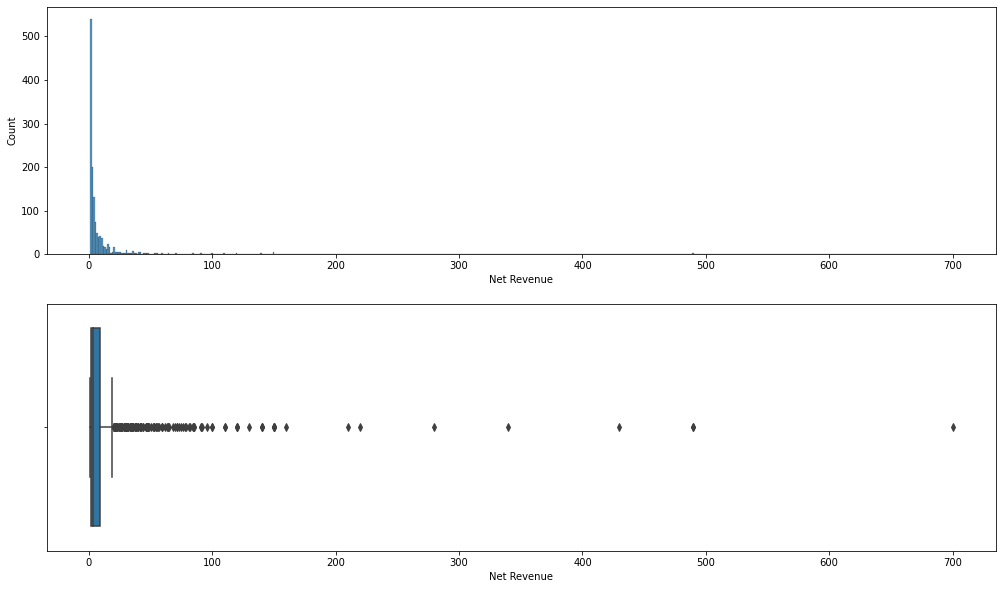

In [4]:
fig, axes = plt.subplots(2, 1)
fig.set_figheight(10)
fig.set_figwidth(17)
sns.histplot(df["Net Revenue"], ax = axes[0])
sns.boxplot(df["Net Revenue"], ax = axes[1])

#### Histogram của biến Price
- đồ thị lệch trái, chủ yếu là từ 8$ đến 60$, nhiều nhất là 20$
- chút nữa xử lý ngoại lệ theo IQR

g:\Code\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Price'>

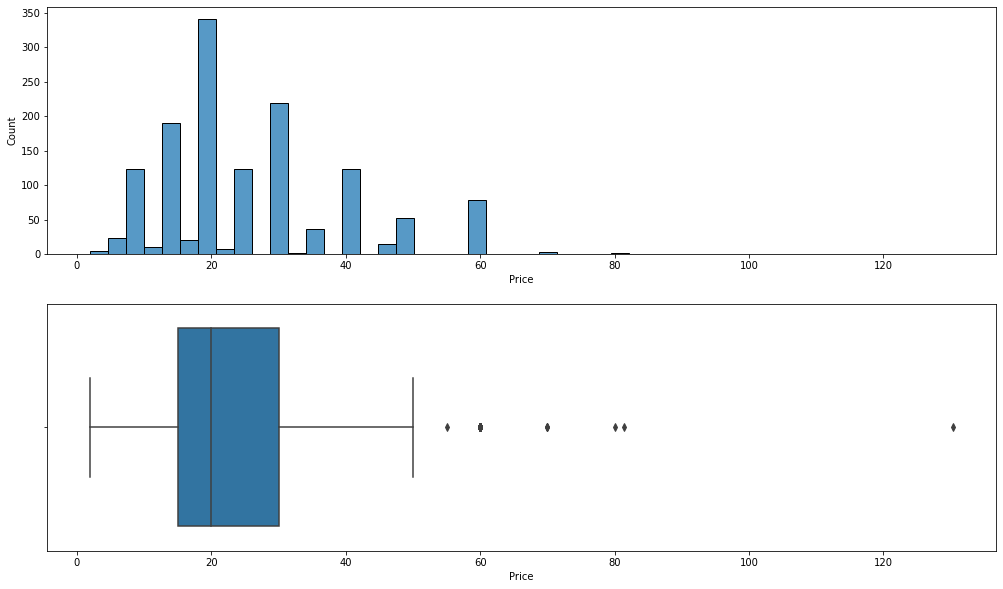

In [5]:
fig, axes = plt.subplots(2, 1)
fig.set_figheight(10)
fig.set_figwidth(17)
sns.histplot(df["Price"], ax = axes[0])
sns.boxplot(df["Price"], ax = axes[1])

#### Biểu đồ scatter plot giữa 2 biến Price và Net Revenue => không có sự tương quan giữa 2 biến

<AxesSubplot:xlabel='Price', ylabel='Net Revenue'>

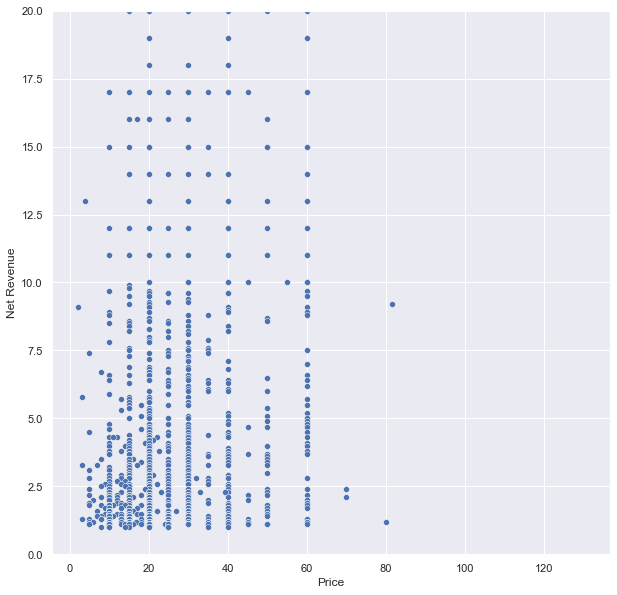

In [6]:
sns.set(rc={'figure.figsize':(10,10)})
fig, ax = plt.subplots()
ax.set_ylim(0,20)
sns.scatterplot(x = "Price", y = "Net Revenue", data = df, ax=ax)

#### Hàm xử lý ngoại lệ theo phân bố lệch

In [7]:
def XuLyNgoaiLe_PhanBoLech(df_in, col):
    df_out = df_in.copy()
    iqr = df_out[col].quantile(0.75) - df_out[col].quantile(0.25)
    upperBoundary = df_out[col].quantile(0.75) + 1.5*iqr
    lowerBoundary = df_out[col].quantile(0.25) - 3*iqr
    df_out.loc[df_out[col] > upperBoundary, col] = upperBoundary
    df_out.loc[df_out[col] < lowerBoundary, col] = lowerBoundary
    return df_out

Đặc trưng Net Revenue sau khi xử lý ngoại lệ

g:\Code\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Net Revenue'>

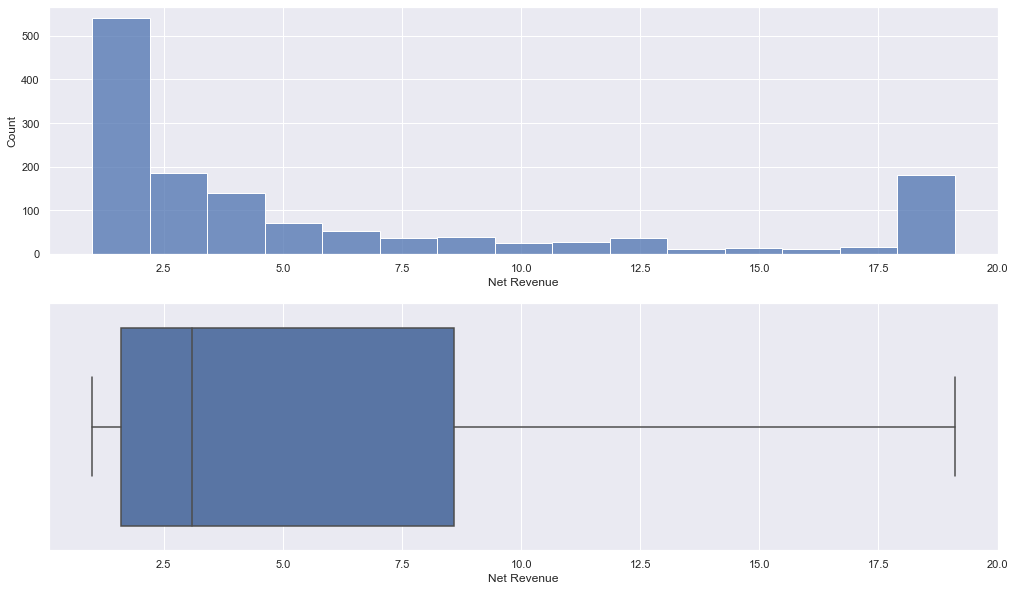

In [8]:
netRevenue_daxuly = XuLyNgoaiLe_PhanBoLech(df, "Net Revenue")["Net Revenue"]
fig, axes = plt.subplots(2, 1)
fig.set_figheight(10)
fig.set_figwidth(17)
sns.histplot(netRevenue_daxuly, ax = axes[0])
sns.boxplot(netRevenue_daxuly, ax = axes[1])

Đặc trưng Price sau khi xử lý ngoại lệ

g:\Code\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Price'>

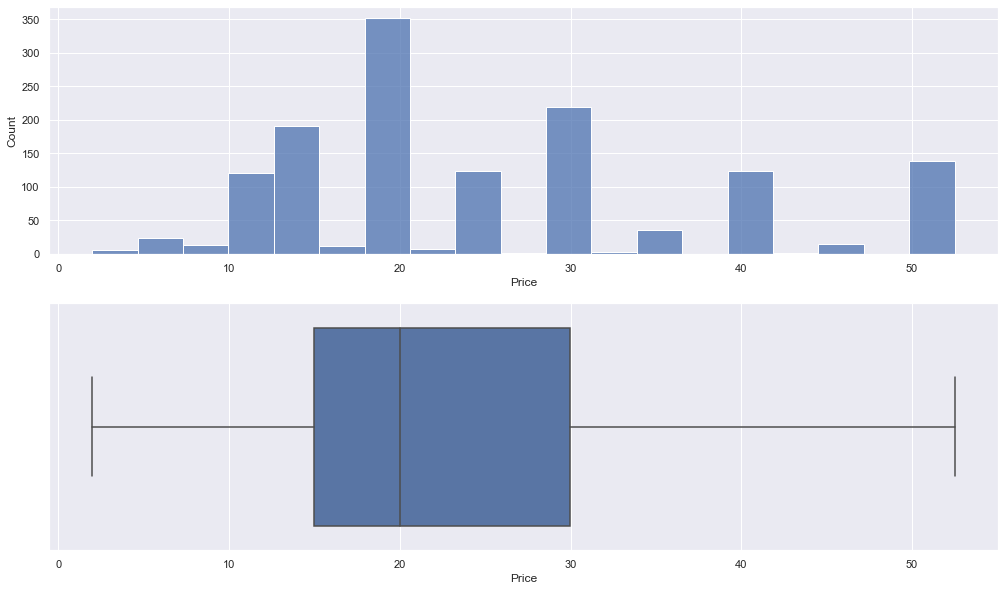

In [9]:
netRevenue_daxuly = XuLyNgoaiLe_PhanBoLech(df, "Price")["Price"]
fig, axes = plt.subplots(2, 1)
fig.set_figheight(10)
fig.set_figwidth(17)
sns.histplot(netRevenue_daxuly, ax = axes[0])
sns.boxplot(netRevenue_daxuly, ax = axes[1])

# Mô hình hoá dữ liệu

## SVR

Giả sử có tập dữ liệu huấn luyện {(x1,y1),...,(xn, yn)}, x là đầu vào, y là kết quả. Mục đích của hồi quy vector hỗ trợ SVR đó là tìm ra 
1 hàm f(x) có sai số nhỏ nhất so với mục tiêu thực sự thu được đó là y

#### Dữ liệu train và dữ liệu test
Chia dữ liệu thành 2 phần:
- x: 4 cột thuộc tính Pulisher, Price, Platform và Genres đã được chuẩn hoá về dạng số thực
- y: mảng các số thực chỉ doanh thu của game
Chia ra 4 mẫu dữ liệu: x_train, y_train, x_test, y_test với tập dữ liệu test chiếm 30% dataset

#### Train

In [10]:
x = df[["Pulisher", "Price", "Platform", "Genres"]]
y = pd.DataFrame(df, columns=["Net Revenue"])
# vì tập dữ liệu nhỏ nên xử lý ngoại lệ trên cả tập train lẫn tập test
x = XuLyNgoaiLe_PhanBoLech(x, "Price")
y = XuLyNgoaiLe_PhanBoLech(y, "Net Revenue")["Net Revenue"]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)
pipe = Pipeline([("transformer", RobustScaler()), ("estimator", SVR())])
pipe.fit(X_train, y_train)

Pipeline(steps=[('transformer', RobustScaler()), ('estimator', SVR())])

#### Test

In [11]:
y_test_pred = pipe.predict(X_test)

#### Bảng kết quả độ lệch

In [12]:
result1 = pd.DataFrame(data=np.array([y_test, y_test_pred, abs(y_test - y_test_pred)]).T, columns=["y thực tế", "y dự đoán SVR", "Lệch SVR"])
result1.head(10)

,y thực tế,y dự đoán SVR,Lệch SVR
0,3.5,2.126923,1.373077
1,1.8,2.845639,1.045639
2,5.8,2.985528,2.814472
3,3.7,1.930127,1.769873
4,5.6,1.643812,3.956188
5,19.1,2.180940,16.919060
6,14.0,4.786522,9.213478
7,16.0,2.671805,13.328195
8,4.4,3.497342,0.902658
9,7.5,3.344061,4.155939


#### Sử dụng độ đo RMSE (căn bậc 2 của trung bình bình phương lỗi) 
> $\text{RMSE}(y, \hat{y}) = \sqrt{\frac{1}{m} \sum\limits_{i=1}^{m} (y_i - \hat{y}_i)^2}$

In [13]:
rmse_SVR = math.sqrt(mean_squared_error(y_test, y_test_pred))
print(f'RMSE = {rmse_SVR}')

RMSE = 6.137316679022097


#### Sử dụng MAE (độ lệch trung bình tuyệt đối)
Mean Absolute Error = (1/n) * ∑|yi – xi|

In [14]:
mae_SVR = mean_absolute_error(y_test,y_test_pred)
print(f'MAE = {mae_SVR}')

MAE = 3.9297177315173655


## Linear regression

<h2>HƯỚNG GIẢI QUYẾT</h2>
<h5><p>Gọi y là doanh thu dự đoán của game</p>
    <p>Gọi x1, x2, x3, x4 lần lượt là Pulisher, Price, Platform và Genres</p>
    <p>Với mô hình Linear Regression theo dạng Multiple Variables ta có công thức:</p>
    <p>y = m0 + m1.x1 + m2.x2 + m3.x3 + m4.x4</p>
    <p>Mục tiêu: tìm được tập số [m0, m1, m2, m3 , m4]</p></h5>


<h2>1. Dữ liệu train và dữ liệu test</h2>
<h5><p>Chia dữ liệu thành 2 phần:</p>
    <p>- Input: 4 cột thuộc tính Pulisher, Price, Platform và Genres đã được chuẩn hoá về dạng số thực</p>
    <p>- Target: mảng các số thực chỉ doanh thu của game</p></h5>
<h5>Chia ra 4 mẫu dữ liệu: input_train, target_train, input_test, target_test với tập dữ liệu test chiếm 30% dataset<h5>

In [15]:
input = df[['Pulisher', 'Price', 'Platform', 'Genres']]
# vì tập dữ liệu nhỏ nên xử lý ngoại lệ trên cả tập train lẫn test
rs = RobustScaler()
input = XuLyNgoaiLe_PhanBoLech(input,"Price")
target = XuLyNgoaiLe_PhanBoLech(df, "Net Revenue")["Net Revenue"]
input_train,input_test,target_train,target_test = train_test_split(input, target, test_size=0.3, random_state=0)
input_train = pd.DataFrame(rs.fit_transform(input_train), columns=input_train.columns)
input_test = pd.DataFrame(rs.transform(input_test), columns=input_test.columns)

<h2>2. Xây dựng mô hình Linear Regression sử dụng Sklearn</h2>

In [16]:
# Xây dựng mô hình hồi quy tuyến tính sử dụng thư viện scikit-learn
l_regr = linear_model.LinearRegression()

<h2>3. Huấn luyện mô hình</h2>
<h4><p>Sử dụng dữ liệu input và target đã chia ở bước 1 để huấn luyện mô hình</p>
       ==> Tìm được [m0, m1, m2 ,m3 ,m4]<h4>

In [17]:
# huấn luyện mô hình
l_regr.fit(input_train, target_train)
print("[m1,m2,m3,m4] = ", l_regr.coef_)
print("m0 = ", l_regr.intercept_)

[m1,m2,m3,m4] =  [ 0.32601963  2.30330001  0.79490784 -1.21524662]
m0 =  4.908085492592432


<h2>4. Dự đoán các mẫu dữ liệu trong tập dữ liệu test</h2>


In [18]:
# Thực hiện phán đoán cho dữ liệu mới
target_test_pred = l_regr.predict(input_test)

Bảng so sánh giữa doanh thu thực tế, doanh thu dự đoán và độ lệnh giữa chúng:

In [19]:
result2 = pd.DataFrame(data=np.array([target_test, target_test_pred,
abs(target_test - target_test_pred)]).T, columns=["y thực tế", "y dự đoán LR", "Lệch LR"])
print(result2.head(10))

   y thực tế  y dự đoán LR    Lệch LR
0        3.5      4.154337   0.654337
1        1.8      4.737512   2.937512
2        5.8      5.493835   0.306165
3        3.7      3.457367   0.242633
4        5.6      3.565295   2.034705
5       19.1      4.174826  14.925174
6       14.0      8.714472   5.285528
7       16.0      5.177229  10.822771
8        4.4      6.449122   2.049122
9        7.5      6.284536   1.215464


Sử dụng độ đo RMSE (căn bậc 2 của trung bình bình phương lỗi) 
> $\text{RMSE}(y, \hat{y}) = \sqrt{\frac{1}{m} \sum\limits_{i=1}^{m} (y_i - \hat{y}_i)^2}$

In [20]:
rmse_LR = math.sqrt(mean_squared_error(target_test, target_test_pred))
print(f'RMSE = {rmse_LR}')

RMSE = 5.614153027476399


#### Sử dụng MAE (độ lệch trung bình tuyệt đối)
Mean Absolute Error = (1/n) * ∑|yi – xi|

In [21]:
mae_LR = mean_absolute_error(target_test, target_test_pred)
print(f'MAE = {mae_LR}')

MAE = 4.3848351838120605


# So sánh 2 mô hình

### Độ lệch dự đoán so với thực tế

In [22]:
result = pd.DataFrame(result1, columns=["y thực tế", "y dự đoán SVR"])
result["y dự đoán LR"] = result2["y dự đoán LR"]
result["Lệch SVR"] = result1["Lệch SVR"]
result["Lệch LR"] = result2["Lệch LR"]
result.sort_values(by=["y thực tế"], inplace=True, ignore_index=True)
print(result.head(10))

   y thực tế  y dự đoán SVR  y dự đoán LR  Lệch SVR   Lệch LR
0        1.0       2.367549      6.871677  1.367549  5.871677
1        1.0       2.970788      4.922115  1.970788  3.922115
2        1.0       1.367374      3.367474  0.367374  2.367474
3        1.0       5.206065      7.721348  4.206065  6.721348
4        1.0       1.290167      3.247670  0.290167  2.247670
5        1.0       3.642333      5.472611  2.642333  4.472611
6        1.1       2.947422      4.887157  1.847422  3.787157
7        1.1       3.950321      7.165948  2.850321  6.065948
8        1.1       2.238804      5.087673  1.138804  3.987673
9        1.1       4.696645      6.689457  3.596645  5.589457


#### Biểu đồ histogram thể hiện độ lệch của 2 thuật toán so với thực tế

<AxesSubplot:xlabel='Lệch LR', ylabel='Count'>

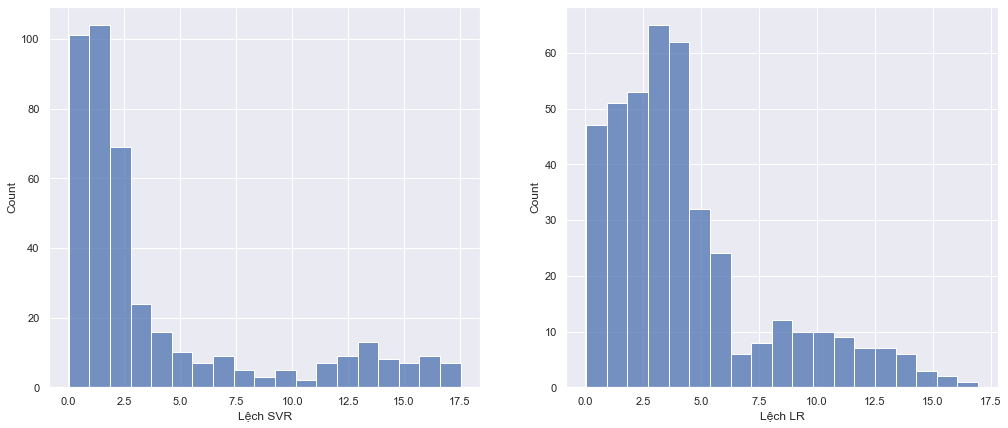

In [23]:
fig, axes = plt.subplots(1, 2)
fig.set_figheight(7)
fig.set_figwidth(17)
sns.histplot(result["Lệch SVR"], ax = axes[0])
sns.histplot(result["Lệch LR"], ax = axes[1])
# Có thể thấy thuật toán SVR cho đỘ lệch thấp hơn so với Linear regression

#### Biểu đồ lineplot thể hiện độ lệch của 2 thuật toán so với thực tế

[Text(0.5, 1.0, 'Support vector regression')]

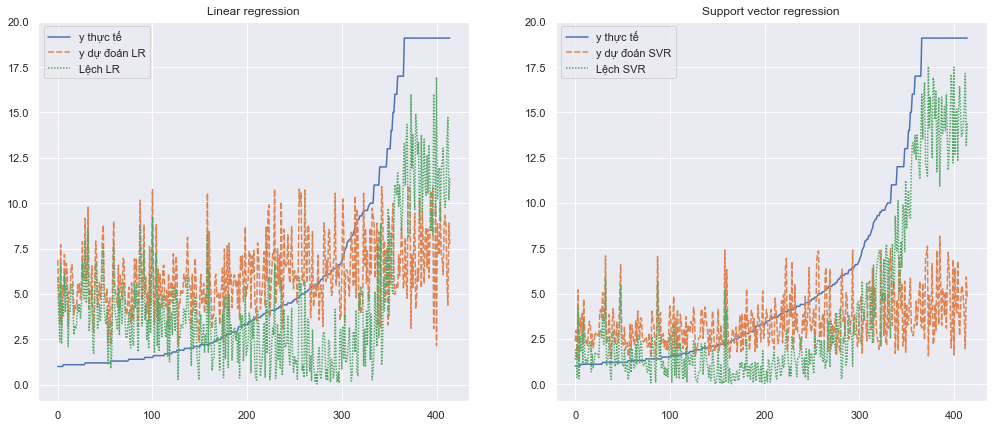

In [24]:
fig, axes = plt.subplots(1, 2)
fig.set_figheight(7)
fig.set_figwidth(17)
sns.lineplot(data = result[["y thực tế", "y dự đoán LR", "Lệch LR"]], sort=False, ax=axes[0]).set(title="Linear regression")
sns.lineplot(data = result[["y thực tế", "y dự đoán SVR", "Lệch SVR"]], sort=False, ax=axes[1]).set(title="Support vector regression")
# y thực tế càng cao thì độ lệch dự đoán càng cao, vì các giá trị y thực tế cao phần lớn là ngoại lệ
# dự đoán của SVR gần với đường y thực tế hơn, cho độ chính xác tốt hơn, tuy nhiên từ index 300->400 LR cho ra giá trị chính xác hơn
# giá trị dự đoán của LR nằm từ 2->11, trong khi đó SVR trong khoảng 1->8

Nếu cho độ lệch < 2 là chính xác thì

In [25]:
# tạo column mới nếu có độ lệch < 2 thì sẽ có giá trị là 1
result["chính xác SVR"] = np.where(result["Lệch SVR"] < 2., 1, 0)
result["chính xác LR"] = np.where(result["Lệch LR"] < 2., 1, 0)
print(result.head(10))

   y thực tế  y dự đoán SVR  y dự đoán LR  Lệch SVR   Lệch LR  chính xác SVR  \
0        1.0       2.367549      6.871677  1.367549  5.871677              1   
1        1.0       2.970788      4.922115  1.970788  3.922115              1   
2        1.0       1.367374      3.367474  0.367374  2.367474              1   
3        1.0       5.206065      7.721348  4.206065  6.721348              0   
4        1.0       1.290167      3.247670  0.290167  2.247670              1   
5        1.0       3.642333      5.472611  2.642333  4.472611              0   
6        1.1       2.947422      4.887157  1.847422  3.787157              1   
7        1.1       3.950321      7.165948  2.850321  6.065948              0   
8        1.1       2.238804      5.087673  1.138804  3.987673              1   
9        1.1       4.696645      6.689457  3.596645  5.589457              0   

   chính xác LR  
0             0  
1             0  
2             0  
3             0  
4             0  
5          

In [26]:
print("SVR: \n" + str(result["chính xác SVR"].value_counts(1)))
print("LR: \n" + str(result["chính xác LR"].value_counts(1)))

SVR: 
1    0.525301
0    0.474699
Name: chính xác SVR, dtype: float64
LR: 
0    0.751807
1    0.248193
Name: chính xác LR, dtype: float64


### Điểm RMSE và MAE

In [27]:
print("RMSE SVR: " + str(rmse_SVR))
print("MAE  SVR: " + str(mae_SVR))
print("RMSE  LR: " + str(rmse_LR))
print("MAE   LR: " + str(mae_LR))

RMSE SVR: 6.137316679022097
MAE  SVR: 3.9297177315173655
RMSE  LR: 5.614153027476399
MAE   LR: 4.3848351838120605
